![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz


In [88]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [137]:
# Celda 1.1
bikes.groupby('workingday').total.mean()


workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [136]:
Xworkingday=bikes['workingday']
print(Xworkingday.describe())

count    10886.000000
mean         0.680875
std          0.466159
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: workingday, dtype: float64


In [90]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [138]:
Xhour=bikes['hour']
print(Xhour.describe())

count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64


### Workingday:
Es una varible categorica entre 0 y 1, tiene 10886 datos (Es decir que no tiene faltantes) y es una clase balanceada

### Hour:
Es una variable continua entre 0 y 23 que son las horas del dia. Tiene los mismo 10886 datos (es decir que no tiene faltantes).

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

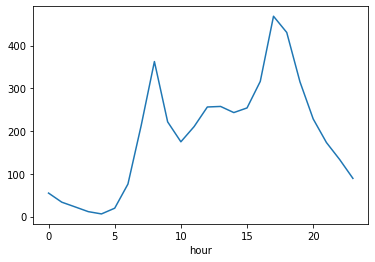

In [91]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

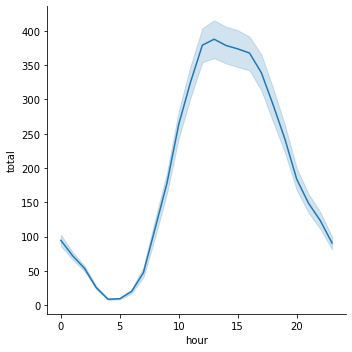

In [95]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
import seaborn as sns
sns.relplot(
    data=bikes[bikes.workingday == 0], 
    x="hour", y="total", 
    kind="line"
)

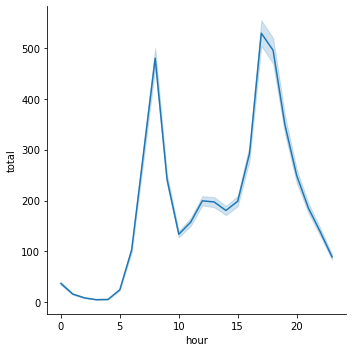

In [96]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
import seaborn as sns
sns.relplot(
    data=bikes[bikes.workingday == 1], 
    x="hour", y="total", 
    kind="line"
)

Comparando las ventas por hora cuando es un dia laboral y cuando no es un dia laboral, se puede concluir que en los dias laborales el flujo de ventas desciende entre las horas 10 y 15, mientras que cuando es un dia no laboral, se tiene un flujo continuo en las ventas desde la hora 5.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [121]:
# Celda 3
from sklearn.metrics import mean_squared_error, r2_score
x_columns = ['hour', 'workingday']
y_columns = ['total']

x = bikes[x_columns]
y = bikes[y_columns]

modelo = LinearRegression()
modelo.fit(x, y)
prediccion=modelo.predict(x)
MSE=np.average(np.square(prediccion-y))
print('El MSE es:', MSE)
print("Coefficient of determination: %.2f" % r2_score(y, prediccion))
print('coeficientes:', modelo.coef_)
print('Intercepto: ', modelo.intercept_)

27541.255252498402

Dado que el R cuadrado es 0.16 se puede concluir que la regresion lineal no es un buen modelo para predecir ya que los datos no se ajustan a relacion lineal. La limitacion de este tipo de regresion es que solo se puede modelar una relacion lineal entre las variables predictoras y la variable independiente Y. Por lo tanto, es recomendable utilizar otros modelos no lineales para predecir mejor. Por otro lado, los coeficientes representan el cambio en la variable independiente por cada unidad de cambio en la variable predictora.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [184]:
def split(x,y, depth, max_depth):
    if depth == max_depth or len(x) < 2:
        return {'prediction': np.mean(y)}
    rule = find_best_rule(x,y)
    left_x=x[rule['feature']] < rule['threshold']
    rule ['left'] = split(x[left_x], y[left_x], depth +1,max_depth)
    rule ['right'] = split(x[~left_x], y[~left_x], depth +1,max_depth)
    return rule

    rules = split(x,y,0,max_depth)
    
def find_best_rule(x,y):
    best_feature,best_threshold,min_rss = None, None, np.inf
    for feature in x.columns:
        threshold = x[feature].unique().tolist()
        threshold.sort()
        threshold = threshold[1:]
        for t in threshold:
            y_left_x = x[feature]<t
            y_left, y_right= y[y_left_x], y[~y_left_x]
            t_rss = rss(y_left,y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    return {'feature':best_feature, 'threshold':best_threshold }

def predict(samples, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample['feature']< threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

##Codigo obtenido de internet en towardsdatascience.com publicado por Riza Ozcelik en mayo 16 del 2020



### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [124]:
# Celda 5
from sklearn.tree import DecisionTreeRegressor
arbol = DecisionTreeRegressor()
arbol  = arbol.fit(x,y)
prediccion_arbol=arbol.predict(x)

print("Coefficient of determination: %.2f" % r2_score(y, prediccion_arbol))

Coefficient of determination: 0.65


El arbol de decision tiene un desempeño mucho mejor que el modelo construido en el punto 3 con la regresion lineal ya que su R cuadrado aumenta de 0.16 a 0.65. Esto rectifica que segun la naturaleza de los datos, no es posible relacionar las variables independientes con las dependientes por medio de una funcion lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [37]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [38]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [39]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

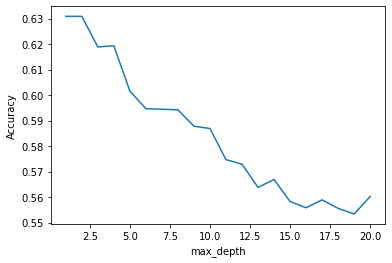

In [147]:
# Celda 6
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

###Arbol de decision
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []
# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)
pred_arbol=clf.predict(X_test)

# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X_test, y_test, cv=10)).describe()

###Regresion logistica
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train,y_train)
pred_regr = model.predict(X_test)

In [152]:
## Arbol de decision
metrics.f1_score(pred_arbol, y_test), metrics.accuracy_score(pred_arbol, y_test)

(0.6448598130841121, 0.6453333333333333)

In [153]:
## Regresion logistica
metrics.f1_score(pred_regr, y_test), metrics.accuracy_score(pred_regr, y_test)

(0.6027972027972027, 0.6213333333333333)

Comparando los resultados del arbol de decision y la regresion logistica, se puede concluir que el arbol de decision tiene un mejor desempeño que la regresion ya que ambos indicadores (F1 y accuracy) son mayores

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [170]:
# Celda 7
#max_depth = None
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=None,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Max_depth = None: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))


#max_depth = 2
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=2,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Max_depth = 2: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

##100 regresiones logisticas
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('100 regresiones logisticas: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

Max_depth = None:  0.6567567567567568 0.6613333333333333
Max_depth = 2:  0.631578947368421 0.6453333333333333
100 regresiones logisticas:  0.6136210384356034 0.618


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [175]:
# Celda 8
##max_depth = None
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=None,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print('Max_depth=None: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

##max_depth = 2
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=2,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print('Max_depth = 2:', metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

##100 regresiones logisticas

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print('Regresiones logisticas:', metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

Max_depth=None:  0.6631087391594397 0.6633333333333333
Max_depth = 2: 0.6324549237170597 0.6466666666666666
Regresiones logisticas: 0.6153846153846154 0.62


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

# Celda 9

El mejor modelo predictor para predecir la popularidad de las noticias es el esamblaje de 100 arboles donde la maxima profundidad del arbol sea igual a None. Esto se puede concluir ya que es el modelo con los F1 y el accuracy mas alto de todos los modelos calculados en los puntos 7 y 8. La desventaja de votacion ponderada es que utiliza mas recursos computacionales que la votacion mayoritaria.